In [2]:
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
from torchsummary import summary
from torch.optim import RAdam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Baseline version

In [3]:

# 自动选择 CPU 或 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR-10 数据集路径（修改为 HPC 服务器的路径）
cifar10_dir = './data/cifar-10-python/cifar-10-batches-py'
cifar_test_path = './data/cifar_test_nolabel.pkl'

# 加载 CIFAR-10 数据集的 batch
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 加载元数据（标签）
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# 加载训练数据
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为 HWC 格式
train_labels = np.array(train_labels)

# 数据增强和归一化
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # 增强平移
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)  # 降低随机擦除强度
])

# 转换为 TensorDataset 并应用变换
train_dataset = [(transform(img), label) for img, label in zip(train_data, train_labels)]

# 划分训练集和验证集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 加载测试集
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为 HWC 格式

# 转换测试数据集为 Tensor
test_dataset = [(transform(img)) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# 训练模型
def train_model(model, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=5e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)



    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 验证
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

# 定义自定义 ResNet 模型
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = ResidualBlock(64, 128, stride=1)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
        
def evaluate_model(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Final {dataset_name} Accuracy: {accuracy:.2f}%')
    return accuracy
    
# 训练模型
model = CustomResNet().to(device)
# 输出模型结构和参数总量
summary(model, (3, 32, 32))

train_model(model, train_loader, val_loader, epochs=50)

# 计算并输出最终的验证集和测试集准确率
final_val_accuracy = evaluate_model(model, val_loader, "Validation Set")


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
            Conv2d-6          [-1, 128, 32, 32]          73,728
       BatchNorm2d-7          [-1, 128, 32, 32]             256
              ReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,456
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
    ResidualBlock-13          [-1, 128, 32, 32]               0
           Conv2d-14

ValueError: too many values to unpack (expected 2)

# 加上Mixup

In [7]:

# 自动选择 CPU 或 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR-10 数据集路径（修改为 HPC 服务器的路径）
cifar10_dir = './data/cifar-10-python/cifar-10-batches-py'
cifar_test_path = './data/cifar_test_nolabel.pkl'

# 加载 CIFAR-10 数据集的 batch
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 加载元数据（标签）
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# 加载训练数据
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为 HWC 格式
train_labels = np.array(train_labels)

# 数据增强和归一化
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # 增强平移
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)  # 降低随机擦除强度
])

# 转换为 TensorDataset 并应用变换
train_dataset = [(transform(img), label) for img, label in zip(train_data, train_labels)]

# 划分训练集和验证集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 加载测试集
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为 HWC 格式

# 转换测试数据集为 Tensor
test_dataset = [(transform(img)) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# 定义 MixUp 数据增强函数
def mixup_data(x, y, alpha=0.2):
    """MixUp 数据增强"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)  
    else:
        lam = 1  

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :] 
    y_a, y_b = y, y[index] 
    return mixed_x, y_a, y_b, lam

# 训练模型
def train_model(model, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=5e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # 使用 MixUp 数据增强
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        # 验证
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

# 定义自定义 ResNet 模型
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = ResidualBlock(64, 128, stride=1)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
        
def evaluate_model(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Final {dataset_name} Accuracy: {accuracy:.2f}%')
    return accuracy
    
# 训练模型
model = CustomResNet().to(device)
# 输出模型结构和参数总量
summary(model, (3, 32, 32))

train_model(model, train_loader, val_loader, epochs=50)

# 计算并输出最终的验证集和测试集准确率
final_val_accuracy = evaluate_model(model, val_loader, "Validation Set")


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
            Conv2d-6          [-1, 128, 32, 32]          73,728
       BatchNorm2d-7          [-1, 128, 32, 32]             256
              ReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,456
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
    ResidualBlock-13          [-1, 128, 32, 32]               0
           Conv2d-14

# 深度增加，每个阶段包含多个残差块

必须是32到256，如果是64到512，params = 11,025,994，超过了要求

In [9]:

# 定义 MixUp 数据增强函数
def mixup_data(x, y, alpha=0.2):
    """MixUp 数据增强"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)  
    else:
        lam = 1  

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :] 
    y_a, y_b = y, y[index] 
    return mixed_x, y_a, y_b, lam

# 训练模型
def train_model(model, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=5e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # 使用 MixUp 数据增强
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        # 验证
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

# 定义自定义 ResNet 模型
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        return out

class CustomResNet(nn.Module):
        
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = nn.Sequential(ResidualBlock(32, 64, stride=1), ResidualBlock(64, 64, stride=1))
        self.layer2 = nn.Sequential(ResidualBlock(64, 128, stride=2), ResidualBlock(128, 128, stride=1))
        self.layer3 = nn.Sequential(ResidualBlock(128, 256, stride=2), ResidualBlock(256, 256, stride=1))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
        
def evaluate_model(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Final {dataset_name} Accuracy: {accuracy:.2f}%')
    return accuracy
    
# 训练模型
model = CustomResNet().to(device)
# 输出模型结构和参数总量
summary(model, (3, 32, 32))

train_model(model, train_loader, val_loader, epochs=50)

# 计算并输出最终的验证集和测试集准确率
final_val_accuracy = evaluate_model(model, val_loader, "Validation Set")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
    ResidualBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

# 最终版本

修改内容：
1. 更换test data格式处理，更符合kaggle的要求。
2. 只给train data做数据增强，test data 不做，增强泛化能力。
3. optimizer改成RAdam，lr=0.003改成0.001，weight_decay=5e-5改成1e-4
4. 学习率从scheduler = CosineAnnealingLR(optimizer, T_max=epochs)改成：scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)  # 自适应调整学习率
5. 改变数据增强方法(train_transform)，原来手动指定RandomCrop、ColorJitter、RandomAffine，现在用RandAugment自动调整

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
    ResidualBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14

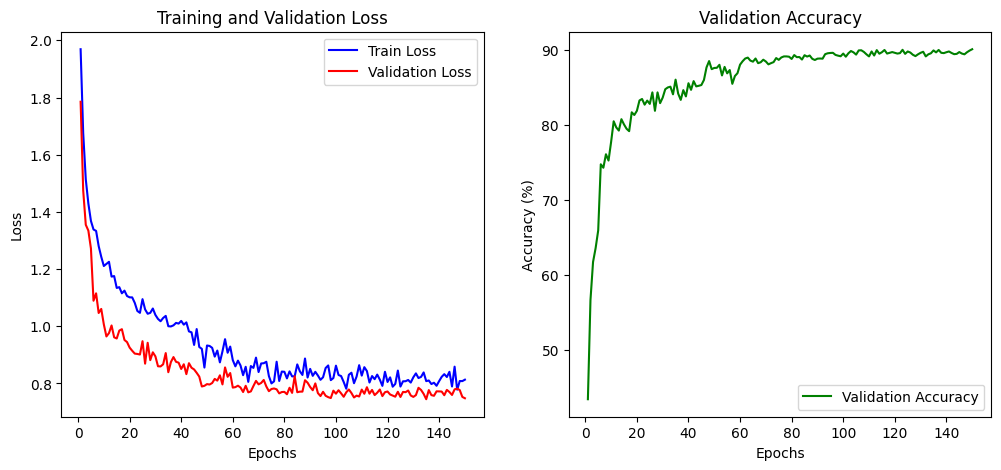

Final Validation Set Accuracy: 90.10%


In [4]:

# 自动选择 CPU 或 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR-10 数据集路径（修改为 HPC 服务器的路径）
cifar10_dir = './data/cifar-10-python/cifar-10-batches-py'
cifar_test_path = './data/cifar_test_nolabel.pkl'

# 加载 CIFAR-10 数据集的 batch
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 加载元数据（标签）
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# 加载训练数据
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

# 处理数据格式
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

# 定义训练数据的 RandAugment（自动数据增强）
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    RandAugment(),  # 自动数据增强
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)
])

# 定义测试数据的 transform
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# 构建训练集（应用 train_transform）
train_dataset = [(train_transform(img), label) for img, label in zip(train_data, train_labels)]

# 划分训练集和验证集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 加载测试集
test_batch = load_cifar_batch(cifar_test_path)
raw_data = test_batch[b'data']
# 假设 raw_data 已经是 (10000, 32, 32, 3) 的 HWC 格式
test_images = raw_data.astype(np.uint8)
# 构建测试集（应用 test_transform）
test_dataset = [test_transform(img) for img in test_images]

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


# 定义 MixUp 数据增强函数
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


# 定义训练函数（使用 MixUp）
def train_model(model, train_loader, val_loader, epochs=150):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = RAdam(model.parameters(), lr=0.001, weight_decay=1e-4)  # 用 RAdam 替换 AdamW
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)  # 自适应调整学习率
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # 使用 MixUp 数据增强
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # 计算平均训练损失
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 验证阶段（不使用 MixUp）
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0  # 记录验证损失
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # 计算验证损失
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total  # 计算验证集准确率
        val_loss /= len(val_loader)  # 计算平均验证损失
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)  # 传入验证集准确率，调整学习率

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, ' +
              f'Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses, val_accuracies

# 绘制训练曲线
def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()
    
# 定义 Residual Block 模块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        return out

# 定义自定义 ResNet 模型
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        # 堆叠多个残差块，每个阶段加深网络
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu(self.init_bn(self.init_conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
        
def evaluate_model(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Final {dataset_name} Accuracy: {accuracy:.2f}%')
    return accuracy

# 训练模型并绘制曲线
model = CustomResNet().to(device)
# 输出模型结构和参数总量
summary(model, (3, 32, 32))

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=150)
plot_training_curves(train_losses, val_losses, val_accuracies)

# 计算并输出最终的验证集和测试集准确率
final_val_accuracy = evaluate_model(model, val_loader, "Validation Set")

In [5]:
# 计算测试集的预测结果
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:  # 确保只取 images
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('./submission.csv', index=False)
print("✅ 提交文件已保存：./submission.csv")

✅ 提交文件已保存：./submission.csv
